### Regression models predicting V, A, D seperately (normalized variables)

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


data_01=pd.read_csv('Emo_Bank_VAD.csv')

print(data_01.columns)
print('')
print(data_01.shape)
print(data_01.head())
print('')
print(data_01.dtypes)

Index(['id', 'split', 'V', 'A', 'D', 'text'], dtype='object')

(9906, 6)
                    id  split     V     A     D  \
0  110CYL068_1036_1079  train  3.00  3.00  3.20   
1  110CYL068_1079_1110   test  2.80  3.10  2.80   
2  110CYL068_1127_1130  train  3.00  3.00  3.00   
3  110CYL068_1137_1188  train  3.44  3.00  3.22   
4  110CYL068_1189_1328  train  3.55  3.27  3.46   

                                                text  
0        Remember what she said in my last letter? "  
1                          If I wasn't working here.  
2                                                .."  
3  Goodwill helps people get off of public assist...  
4  Sherry learned through our Future Works class ...  

id        object
split     object
V        float64
A        float64
D        float64
text      object
dtype: object


In [2]:
# Normalize columns 'A', 'V', and 'D'
scaler = MinMaxScaler(feature_range=(-1, 1))

# Apply the scaler to the columns of interest
data_01[['A', 'V', 'D']] = scaler.fit_transform(data_01[['A', 'V', 'D']])


print(data_01.head())

                    id  split         V         A         D  \
0  110CYL068_1036_1079  train  0.058824 -0.076923  0.173554   
1  110CYL068_1079_1110   test -0.058824  0.000000 -0.157025   
2  110CYL068_1127_1130  train  0.058824 -0.076923  0.008264   
3  110CYL068_1137_1188  train  0.317647 -0.076923  0.190083   
4  110CYL068_1189_1328  train  0.382353  0.130769  0.388430   

                                                text  
0        Remember what she said in my last letter? "  
1                          If I wasn't working here.  
2                                                .."  
3  Goodwill helps people get off of public assist...  
4  Sherry learned through our Future Works class ...  


In [3]:
#Ridge regression with GridSearchCV
from sklearn.model_selection import GridSearchCV, train_test_split


# train, validation and test split dataset
x_train, x_test, y_train, y_test = train_test_split(data_01["text"], data_01["A"], test_size = 0.1, shuffle=True, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, shuffle=True, random_state = 1) 
print("Data shapes:", x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape)


# Define a pipeline with TfidfVectorizer and Ridge Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  
    ('ridge', Ridge())  
])

# Define parameter grid for GridSearchCV
param_grid = {
    'tfidf__max_features': [3000, 5000, 7000],  
    'tfidf__ngram_range': [(1, 1), (1, 2)],  
    'ridge__alpha': [0.1, 1.0, 10.0] 
}

# Setup GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(x_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score (Negative MSE):", grid_search.best_score_)

# Make predictions with the best model
y_pred_train_A = grid_search.predict(x_train)
y_pred_val_A = grid_search.predict(x_val)
y_pred_test_A = grid_search.predict(x_test)

# Evaluate the model
print("Arousal")
print("Train RMSE:", round(rmse(y_train, y_pred_train_A), 2))
print("Train MSE:", round(mean_squared_error(y_train, y_pred_train_A), 2))
print("Train MAE:", round(mean_absolute_error(y_train, y_pred_train_A), 2))
print()
print("Validation RMSE:", round(rmse(y_val, y_pred_val_A), 2))
print("Validation MSE:", round(mean_squared_error(y_val, y_pred_val_A), 2))
print("Validation MAE:", round(mean_absolute_error(y_val, y_pred_val_A), 2))
print()
print("Test RMSE:", round(rmse(y_test, y_pred_test_A), 2))
print("Test MSE:", round(mean_squared_error(y_test, y_pred_test_A), 2))
print("Test MAE:", round(mean_absolute_error(y_test, y_pred_test_A), 2))

Data shapes: (8023,) (892,) (991,) (8023,) (892,) (991,)
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'ridge__alpha': 10.0, 'tfidf__max_features': 7000, 'tfidf__ngram_range': (1, 1)}
Best Score (Negative MSE): -0.035989327716039875
Arousal
Train RMSE: 0.18
Train MSE: 0.03
Train MAE: 0.13

Validation RMSE: 0.19
Validation MSE: 0.04
Validation MAE: 0.14

Test RMSE: 0.2
Test MSE: 0.04
Test MAE: 0.15


In [4]:
# Create DataFrames for comparison
train_comparison = pd.DataFrame({
    'Actual_A': y_train,
    'Predicted_A': y_pred_train_A
})

val_comparison = pd.DataFrame({
    'Actual_A': y_val,
    'Predicted_A': y_pred_val_A
})

test_comparison = pd.DataFrame({
    'Actual_A': y_test,
    'Predicted_A': y_pred_test_A
})

# Round predicted values to two decimal places
train_comparison['Predicted_A'] = train_comparison['Predicted_A']
val_comparison['Predicted_A'] = val_comparison['Predicted_A']
test_comparison['Predicted_A'] = test_comparison['Predicted_A']

# Display the comparison tables
print("\nTraining Set Comparison:")
print(train_comparison.head())  
print("\nValidation Set Comparison:")
print(val_comparison.head())
print("\nTest Set Comparison:")
print(test_comparison.head())

# Save the comparison tables to CSV files
train_comparison.to_csv("train_comparison_chain_normA.csv", index=False)
val_comparison.to_csv("val_comparison_chain_normA.csv", index=False)
test_comparison.to_csv("test_comparison_chain_normA.csv", index=False)



Training Set Comparison:
      Actual_A  Predicted_A
5214 -0.307692    -0.073881
4784  0.000000    -0.067062
708   0.000000    -0.013253
6369  0.176923    -0.035857
2135 -0.076923    -0.074117

Validation Set Comparison:
      Actual_A  Predicted_A
7794  0.000000     0.026037
6770 -0.153846    -0.069090
3444  0.253846    -0.021602
1767 -0.076923    -0.075195
8128  0.076923    -0.084429

Test Set Comparison:
      Actual_A  Predicted_A
8687 -0.692308    -0.031642
7972  0.076923    -0.039439
1628 -0.184615    -0.082391
8699 -0.307692    -0.089541
5648 -0.246154    -0.075691


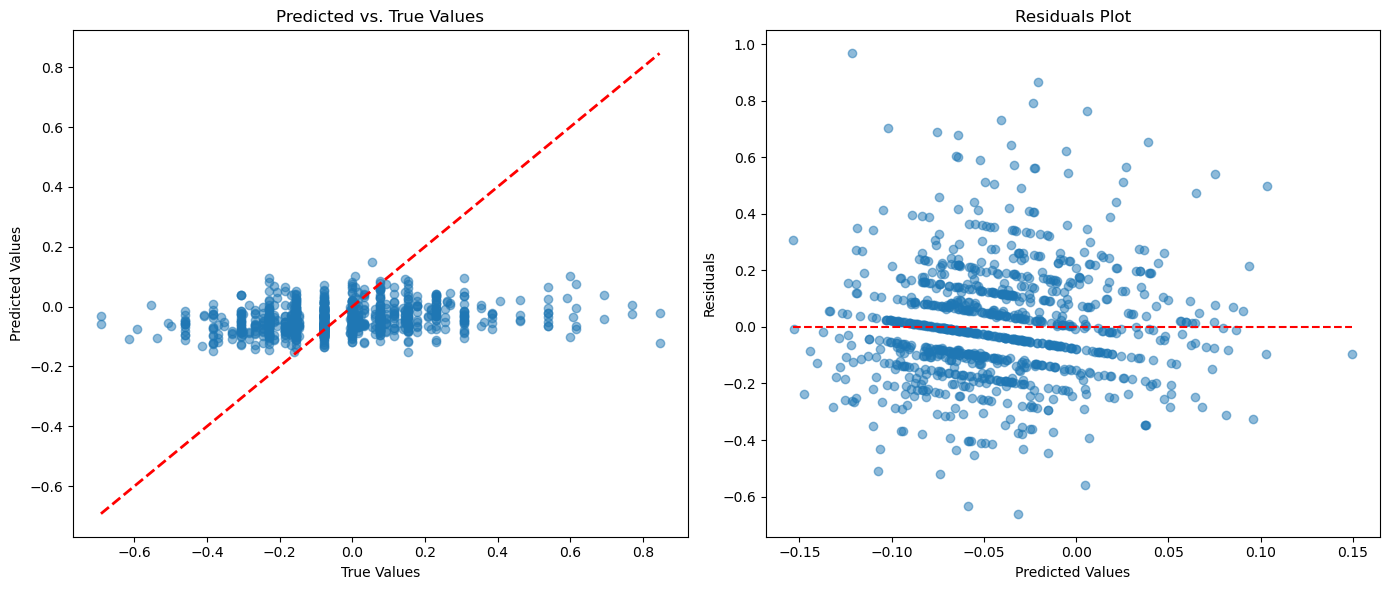

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Predicted vs. Real Values Plot
axs[0].scatter(y_test, y_pred_test_A, alpha=0.5)
axs[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
axs[0].set_xlabel('True Values')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('Predicted vs. True Values')

# Residuals Plot
residuals = y_test - y_pred_test_A
axs[1].scatter(y_pred_test_A, residuals, alpha=0.5)
axs[1].hlines(0, xmin=min(y_pred_test_A), xmax=max(y_pred_test_A), colors='r', linestyles='--')
axs[1].set_xlabel('Predicted Values')
axs[1].set_ylabel('Residuals')
axs[1].set_title('Residuals Plot')

plt.tight_layout()
plt.show()

In [6]:
#Ridge for "Dominance"
from sklearn.model_selection import GridSearchCV
#Split the data
x_train, x_test, y_train, y_test = train_test_split(data_01["text"], data_01["D"], test_size=0.1, shuffle=True, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=1)


# Define a pipeline with TfidfVectorizer and Ridge Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  
    ('ridge', Ridge())  
])

# Define parameter grid for GridSearchCV
param_grid = {
    'tfidf__max_features': [3000, 5000, 7000],  
    'tfidf__ngram_range': [(1, 1), (1, 2)],  
    'ridge__alpha': [0.1, 1.0, 10.0] 
}

# Setup GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(x_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score (Negative MSE):", grid_search.best_score_)

# Make predictions with the best model
y_pred_train_D = grid_search.predict(x_train)
y_pred_val_D = grid_search.predict(x_val)
y_pred_test_D = grid_search.predict(x_test)

# Evaluate the model
print("Train RMSE for Dominance:", round(rmse(y_train, y_pred_train_D), 2))
print("Train MSE for Dominance:", round(mean_squared_error(y_train, y_pred_train_D), 2))
print("Train MAE for Dominance:", round(mean_absolute_error(y_train, y_pred_train_D), 2))
print()
print("Validation RMSE for Dominance:", round(rmse(y_val, y_pred_val_D), 2))
print("Validation MSE for Dominance:", round(mean_squared_error(y_val, y_pred_val_D), 2))
print("Validation MAE for Dominance:", round(mean_absolute_error(y_val, y_pred_val_D), 2))
print()
print("Test RMSE for Dominance:", round(rmse(y_test, y_pred_test_D), 2))
print("Test MSE for Dominance:", round(mean_squared_error(y_test, y_pred_test_D), 2))
print("Test MAE for Dominance:", round(mean_absolute_error(y_test, y_pred_test_D), 2))



Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'ridge__alpha': 10.0, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 2)}
Best Score (Negative MSE): -0.02752418486890046
Train RMSE for Dominance: 0.15
Train MSE for Dominance: 0.02
Train MAE for Dominance: 0.11

Validation RMSE for Dominance: 0.18
Validation MSE for Dominance: 0.03
Validation MAE for Dominance: 0.13

Test RMSE for Dominance: 0.18
Test MSE for Dominance: 0.03
Test MAE for Dominance: 0.13


In [7]:
# Create DataFrames for comparison
train_comparison = pd.DataFrame({
    'Actual_D': y_train,
    'Predicted_D': y_pred_train_D
})

val_comparison = pd.DataFrame({
    'Actual_D': y_val,
    'Predicted_D': y_pred_val_D
})

test_comparison = pd.DataFrame({
    'Actual_D': y_test,
    'Predicted_D': y_pred_test_D
})

# Round predicted values to two decimal places
train_comparison['Predicted_D'] = train_comparison['Predicted_D']
val_comparison['Predicted_D'] = val_comparison['Predicted_D']
test_comparison['Predicted_D'] = test_comparison['Predicted_D']

# Display the comparison tables
print("\nTraining Set Comparison:")
print(train_comparison.head()) 

print("\nValidation Set Comparison:")
print(val_comparison.head())  

print("\nTest Set Comparison:")
print(test_comparison.head())  

# Save the comparison tables to CSV files
train_comparison.to_csv("train_comparison_chain_normD.csv", index=False)
val_comparison.to_csv("val_comparison_chain_normD.csv", index=False)
test_comparison.to_csv("test_comparison_chain_normD.csv", index=False)


Training Set Comparison:
      Actual_D  Predicted_D
5214  0.090909     0.045905
4784 -0.157025     0.032049
708  -0.157025    -0.043557
6369  0.099174     0.068498
2135  0.008264     0.040631

Validation Set Comparison:
      Actual_D  Predicted_D
7794  0.669421     0.052319
6770 -0.074380     0.067095
3444  0.363636     0.034267
1767  0.190083     0.021819
8128  0.090909     0.044167

Test Set Comparison:
      Actual_D  Predicted_D
8687 -0.074380     0.047309
7972 -0.074380     0.074423
1628  0.008264     0.087644
8699  0.090909     0.010512
5648  0.008264     0.070914


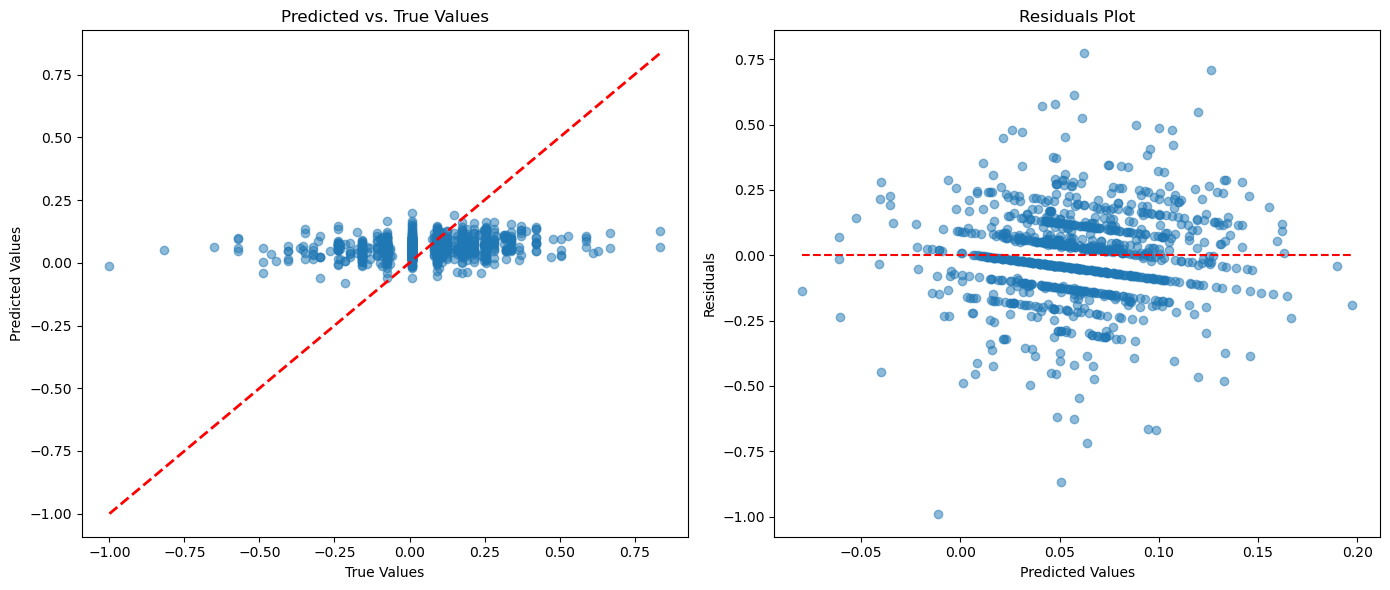

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Predicted vs. Real Values Plot
axs[0].scatter(y_test, y_pred_test_D, alpha=0.5)
axs[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
axs[0].set_xlabel('True Values')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('Predicted vs. True Values')

# Residuals Plot
residuals = y_test - y_pred_test_D
axs[1].scatter(y_pred_test_D, residuals, alpha=0.5)
axs[1].hlines(0, xmin=min(y_pred_test_D), xmax=max(y_pred_test_D), colors='r', linestyles='--')
axs[1].set_xlabel('Predicted Values')
axs[1].set_ylabel('Residuals')
axs[1].set_title('Residuals Plot')

plt.tight_layout()
plt.show()

In [9]:
#Ridge for "Valance"

#Split the data
x_train, x_test, y_train, y_test = train_test_split(data_01["text"], data_01["V"], test_size=0.1, shuffle=True, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=1)


# Define a pipeline with TfidfVectorizer and Ridge Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  
    ('ridge', Ridge())  
])

# Define parameter grid for GridSearchCV
param_grid = {
    'tfidf__max_features': [3000, 5000, 7000],  
    'tfidf__ngram_range': [(1, 1), (1, 2)],  
    'ridge__alpha': [0.1, 1.0, 10.0] 
}

# Setup GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(x_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score (Negative MSE):", grid_search.best_score_)

# Make predictions with the best model
y_pred_train_V = grid_search.predict(x_train)
y_pred_val_V = grid_search.predict(x_val)
y_pred_test_V = grid_search.predict(x_test)

# Evaluate the model
print("Train RMSE for Valence:", round(rmse(y_train, y_pred_train_V), 2))
print("Train MSE for Valence:", round(mean_squared_error(y_train, y_pred_train_V), 2))
print("Train MAE for Valence:", round(mean_absolute_error(y_train, y_pred_train_V), 2))
print()
print("Validation RMSE for Valence:", round(rmse(y_val, y_pred_val_V), 2))
print("Validation MSE for Valence:", round(mean_squared_error(y_val, y_pred_val_V), 2))
print("Validation MAE for Valence:", round(mean_absolute_error(y_val, y_pred_val_V), 2))
print()
print("Test RMSE for Valence:", round(rmse(y_test, y_pred_test_V), 2))
print("Test MSE for Valence:", round(mean_squared_error(y_test, y_pred_test_V), 2))
print("Test MAE for Valence:", round(mean_absolute_error(y_test, y_pred_test_V), 2))



Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'ridge__alpha': 1.0, 'tfidf__max_features': 7000, 'tfidf__ngram_range': (1, 1)}
Best Score (Negative MSE): -0.030589020172924412
Train RMSE for Valence: 0.12
Train MSE for Valence: 0.02
Train MAE for Valence: 0.09

Validation RMSE for Valence: 0.18
Validation MSE for Valence: 0.03
Validation MAE for Valence: 0.13

Test RMSE for Valence: 0.18
Test MSE for Valence: 0.03
Test MAE for Valence: 0.13


In [10]:
# Create DataFrames for comparison
train_comparison = pd.DataFrame({
    'Actual_V': y_train,
    'Predicted_V': y_pred_train_V
})

val_comparison = pd.DataFrame({
    'Actual_V': y_val,
    'Predicted_V': y_pred_val_V
})

test_comparison = pd.DataFrame({
    'Actual_V': y_test,
    'Predicted_V': y_pred_test_V
})

# Round predicted values to two decimal places
train_comparison['Predicted_V'] = train_comparison['Predicted_V']
val_comparison['Predicted_V'] = val_comparison['Predicted_V']
test_comparison['Predicted_V'] = test_comparison['Predicted_V']

# Display the comparison tables
print("\nTraining Set Comparison:")
print(train_comparison.head())  
print("\nValidation Set Comparison:")
print(val_comparison.head())
print("\nTest Set Comparison:")
print(test_comparison.head())

# Save the comparison tables to CSV files
train_comparison.to_csv("train_comparison_chain_normV.csv", index=False)
val_comparison.to_csv("val_comparison_chain_normV.csv", index=False)
test_comparison.to_csv("test_comparison_chain_normV.csv", index=False)


Training Set Comparison:
      Actual_V  Predicted_V
5214  0.058824     0.072689
4784 -0.235294    -0.117867
708  -0.352941    -0.110475
6369  0.388235     0.333926
2135  0.058824     0.057068

Validation Set Comparison:
          Actual_V  Predicted_V
7794  1.176471e-01     0.163328
6770  2.220446e-16     0.078038
3444  5.882353e-02    -0.236564
1767  1.235294e-01     0.003311
8128  5.882353e-02     0.027566

Test Set Comparison:
          Actual_V  Predicted_V
8687  2.220446e-16     0.086086
7972 -1.764706e-01    -0.014455
1628  5.882353e-02     0.041171
8699  2.220446e-16    -0.027942
5648  5.882353e-02     0.099556


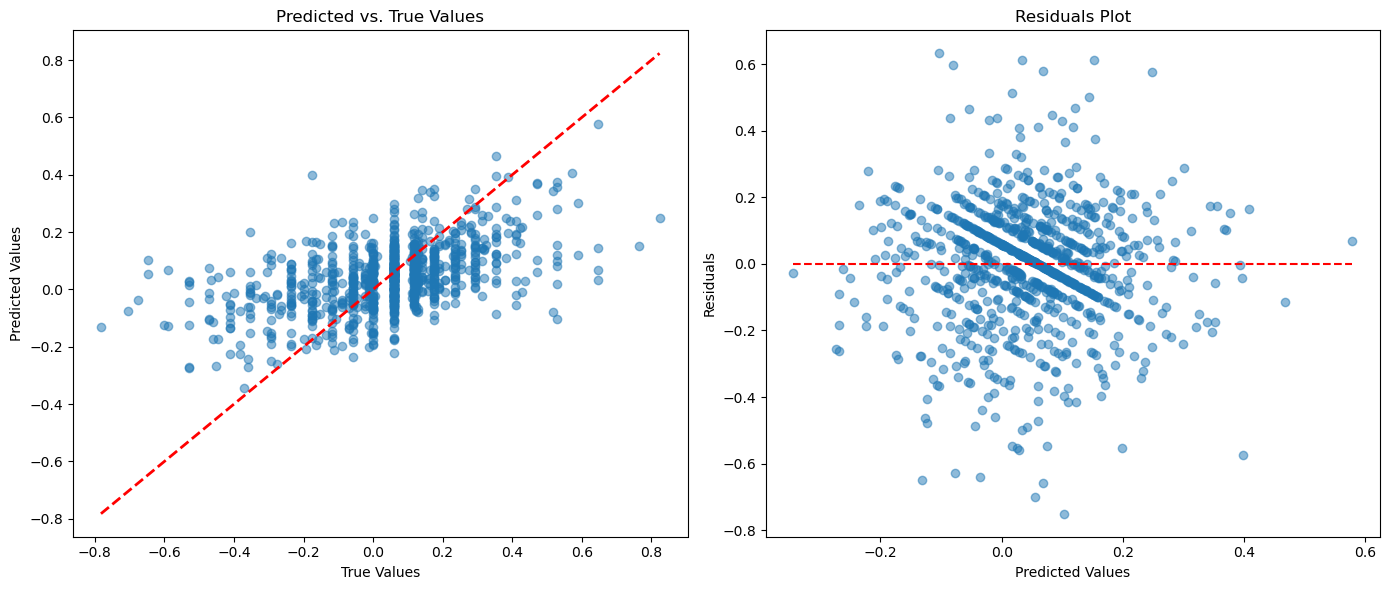

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Predicted vs. Real Values Plot
axs[0].scatter(y_test, y_pred_test_V, alpha=0.5)
axs[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
axs[0].set_xlabel('True Values')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('Predicted vs. True Values')

# Residuals Plot
residuals = y_test - y_pred_test_V
axs[1].scatter(y_pred_test_V, residuals, alpha=0.5)
axs[1].hlines(0, xmin=min(y_pred_test_V), xmax=max(y_pred_test_V), colors='r', linestyles='--')
axs[1].set_xlabel('Predicted Values')
axs[1].set_ylabel('Residuals')
axs[1].set_title('Residuals Plot')

plt.tight_layout()
plt.show()